In [38]:
import os
import re
import statistics
from src.najdi_rok import najdi_rok
from src.pocet_stran import pocet_stran
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [39]:
df = pd.read_parquet(os.path.join("data","cnb_vyber.parquet"))
df['rok'] = df['008'].apply(lambda x: najdi_rok(x))
df['pocet_stran'] = df['300_a'].apply(lambda x: pocet_stran(x))

In [40]:
df['pocet_stran'].quantile([0.1,0.25,0.5,0.75,0.9])

0.10     20.0
0.25     52.0
0.50    121.0
0.75    221.0
0.90    335.0
Name: pocet_stran, dtype: float64

In [41]:
nemala = df['pocet_stran'].quantile(0.25)
nemala

52.0

In [42]:
df = df[df['pocet_stran'] >= nemala]

In [43]:
explo041 = df.explode('041_h')
preklady = explo041[(explo041['041_h'].notnull()) & (explo041['041_h'] != 'cze')]

## Podíl překladové literatury (spíš v datech než v realitě)

<Axes: xlabel='rok'>

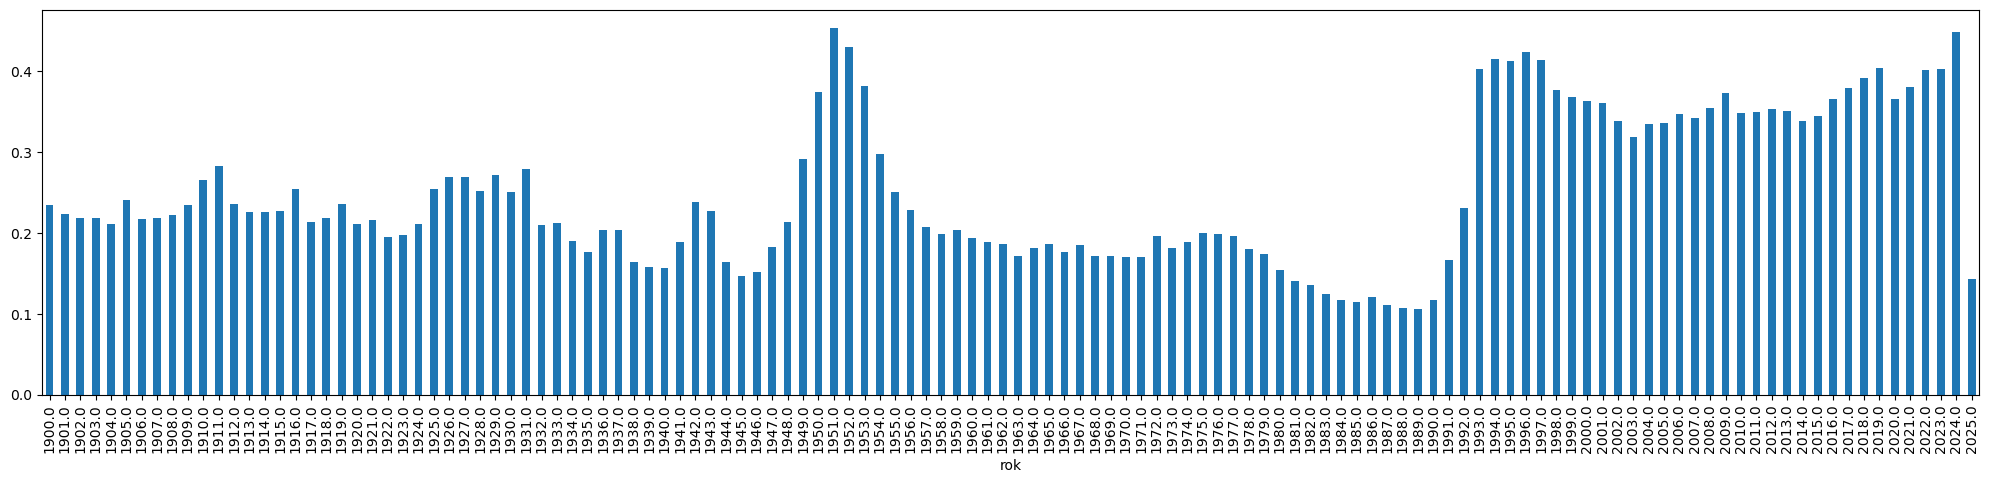

In [45]:
(preklady.groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

In [46]:
(preklady.groupby('rok').size() / df.groupby('rok').size()).nlargest(20)

rok
1951.0    0.453011
2024.0    0.448681
1952.0    0.429930
1996.0    0.423271
1994.0    0.414911
1997.0    0.413993
1995.0    0.413182
2019.0    0.404550
2023.0    0.403227
1993.0    0.402590
2022.0    0.401083
2018.0    0.391623
1953.0    0.381312
2021.0    0.381024
2017.0    0.379319
1998.0    0.376339
1950.0    0.373878
2009.0    0.373330
1999.0    0.368741
2016.0    0.366135
dtype: float64

<Axes: xlabel='rok'>

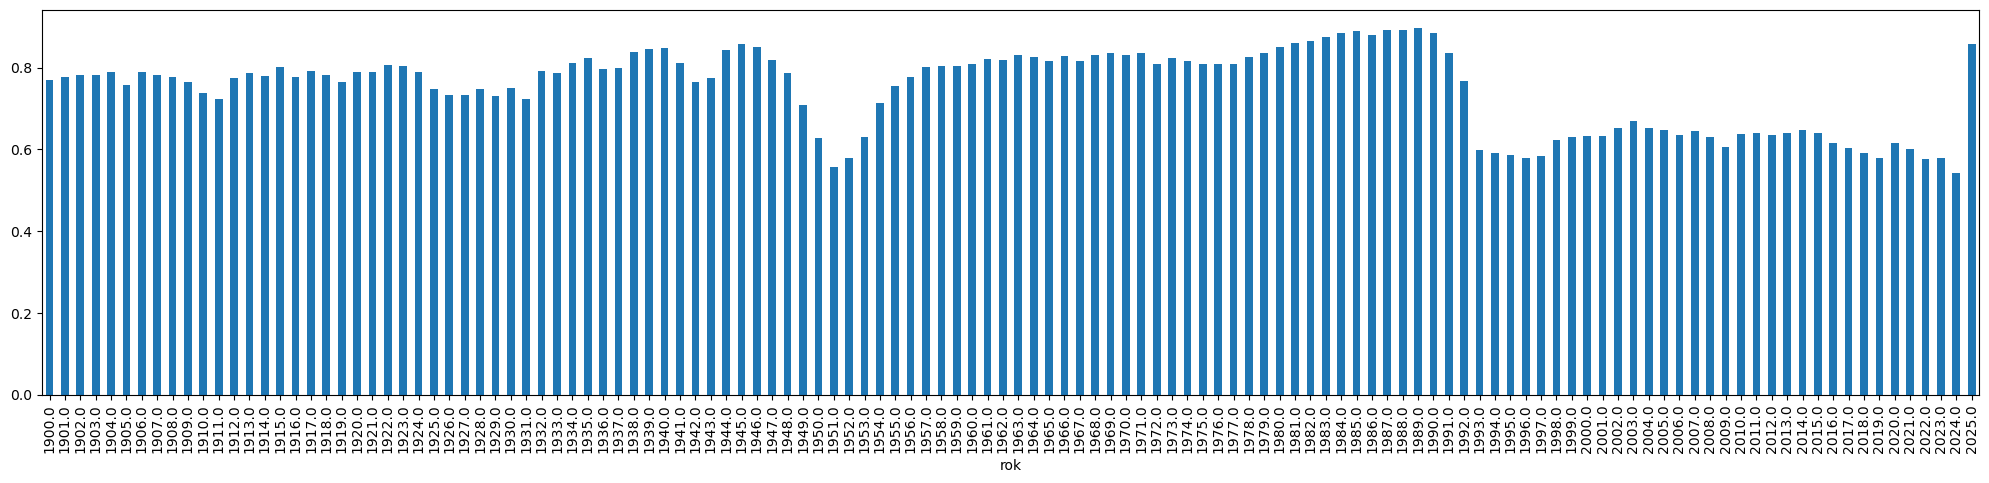

In [47]:
(explo041[explo041['041_h'].isnull()].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

In [48]:
# (~explo041[explo041['041_h'].isnull() | (~explo041['041_h'] == 'cze')].groupby('rok').size() / df.groupby('rok').size()).plot.bar(figsize=(25,5))

## Top jazyky

In [50]:
preklady.groupby('041_h').size().nlargest(40)

041_h
eng    83557
ger    36410
rus    17542
fre    14814
slo     3949
pol     3784
ita     3608
und     2609
spa     2516
lat     1724
swe     1660
mul     1625
dut     1115
hun     1042
nor      965
grc      893
dan      787
jpn      629
bul      536
chi      496
heb      471
fin      412
sla      384
ukr      374
scr      370
por      347
slv      340
rum      280
gre      172
ice      163
ara      158
arc      155
hrv      151
srp      139
san      120
kor      112
est       91
ben       74
tib       74
lav       73
dtype: int64

In [51]:
jazyky = {'eng': 'angličtina', 'ger': 'němčina', 'rus': 'ruština', 'fre': 'francouzština', 'pol': 'polština', 'ita': 'italština', 'slo': 'slovenština', 'spa': 'španělština', 'lat': 'latina', 'swe': 'švédština', 'dut': 'nizozemština', 'hun': 'madarština', 'nor': 'norština','grc':'řečtina','dan':'dánština','jpn':'japonština','bul':'bulharština','chi':'čínština','heb':'hebrejština','fin':'finština'}

In [52]:
top = preklady.groupby('041_h').size().nlargest(20).index.to_list()
top = [t for t in top if t in jazyky.keys()]
print(len(top))
top

18


['eng',
 'ger',
 'rus',
 'fre',
 'slo',
 'pol',
 'ita',
 'spa',
 'lat',
 'swe',
 'dut',
 'hun',
 'nor',
 'grc',
 'dan',
 'jpn',
 'bul',
 'chi']

In [53]:
preklady.groupby('041_h')['rok'].nunique().nlargest(20)

041_h
ger    126
eng    125
ita    125
dan    124
fre    124
lat    124
rus    124
grc    122
pol    121
spa    121
hun    120
nor    118
swe    118
und    116
dut    110
mul    108
slo    105
slv     99
scr     96
bul     93
Name: rok, dtype: int64

In [54]:
top_serie = []
for t in top:
    top_serie.append(pd.Series( preklady[preklady['041_h'] == t].groupby('rok').size() / preklady.groupby('rok').size(), name=jazyky[t]))

japonština


<Axes: xlabel='rok'>

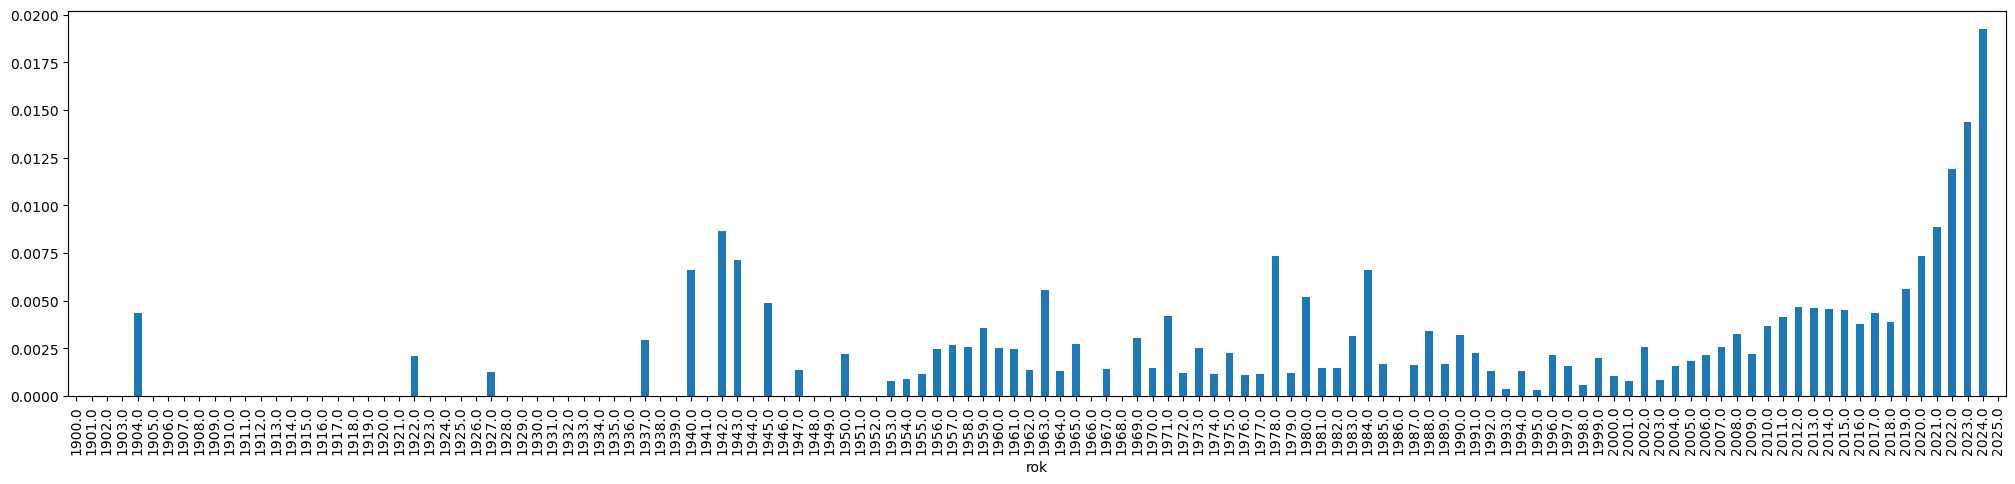

In [55]:
print(top_serie[15].name)
top_serie[15].plot.bar(figsize=(25,5))

## Variabilita / rozptyl

In [57]:
variabilita = {}
for t in top_serie:
    variabilita[t.name] = t.var()
pd.Series(variabilita).sort_values()

čínština         0.000008
japonština       0.000010
nizozemština     0.000029
řečtina          0.000039
španělština      0.000040
švédština        0.000041
dánština         0.000052
madarština       0.000056
norština         0.000060
bulharština      0.000064
latina           0.000124
italština        0.000181
polština         0.000486
slovenština      0.001371
francouzština    0.007419
němčina          0.019023
ruština          0.032473
angličtina       0.036065
dtype: float64

In [59]:
import altair as alt

In [62]:
def irozhlas():

    return {
        "config" : {
             "title": {'font': "Noticia Text",
                      'fontSize': 20,
                      'anchor': 'start',
                    'subtitleFont': 'Noticia Text',
                      'subtitleFontSize': 14,
                      'subtitlePadding': 14,
                       'dy': -14
                      },
             "axis": {
                "labelFont": "Asap",
                "titleFont": "Asap",
                "titleFontWeight": "normal",
                "labelFontSize": 11,
                "titleFontSize": 14,
                'labelPadding': 2,
                 'titlePadding': 10
            },
            "legend": {
                "labelFont": "Asap",
                "labelFontWeight": "normal",
                "titleFont": "Asap",
                "titleFontWeight": "normal",
                "labelFontSize": 11,
                "titleFontSize": 14
            },
        }
    }

alt.themes.register('irozhlas', irozhlas)
alt.themes.enable('irozhlas')

ThemeRegistry.enable('irozhlas')